In [1]:
!mkdir -p ~/.kaggle
!mv /content/kaggle.json ~/.kaggle/kaggle.json

We will download the data directly from Kaggle.

In [2]:
!kaggle datasets download -d puneet6060/intel-image-classification

 97% 337M/346M [00:03<00:00, 88.8MB/s]
100% 346M/346M [00:03<00:00, 107MB/s] 


We need to unzip the data as it is in the zip form.

In [3]:
!unzip -qq intel-image-classification.zip

Importing necessary libraries.

In [29]:
import random
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

Defining the transform for data preprocessing.

In [30]:
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

Loading the train and test dataset.

In [31]:
train_dataset = datasets.ImageFolder('/content/seg_train/seg_train', transform=transform)
test_dataset = datasets.ImageFolder('/content/seg_test/seg_test', transform=transform)

Splitting the data according to:

Train (%65) (10000 images)

Validation (%20) (4000 images)

Test set (%15) (3000 images)

In [32]:
train_size = 10000
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset,[train_size,val_size])

Defining the data loaders.

In [33]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Checking the classes.

In [34]:
class_names = train_dataset.dataset.classes

print("Following classes are there:\n", class_names)

Following classes are there:
 ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Creating a function to see a batch of the images.

In [35]:
def show_batch_images(dataloader): # Taking dataloader as the input.
    
    for images,labels in dataloader: # This line iterates over the dataloader to extract batches of images and their corresponding labels.
        
        fig,ax = plt.subplots(figsize = (16,12)) # This line creates a new figure and axes object using plt.subplots(). The figsize argument sets the size of the figure to (16, 12) inches.
        
        # These lines removes the x-axis and y-axis ticks from the plot. It ensures that there are no tick marks along the axes.
        ax.set_xticks([])
        ax.set_yticks([])

        # This line displays the batch of images in the current axes. 
        # make_grid(images, nrow=16): Creates a grid of images by arranging them in rows with 16 images per row. 
        # permute(1, 2, 0): Rearranges the dimensions of the image tensor from (channels, height, width) to (height, width, channels) to match the expected format for visualization. 
        # ax.imshow(): Displays the image grid in the current axes.
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))

        break # This line breaks the loop after displaying the first batch of images. 

Let's see a batch of images from train set.

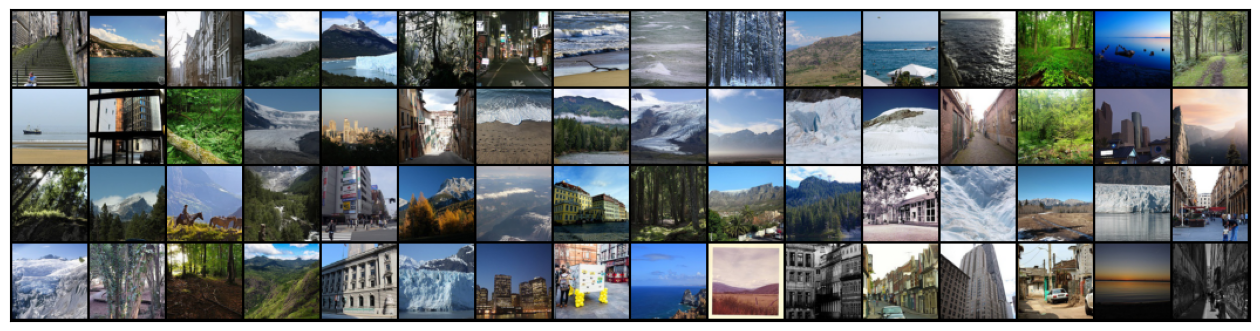

In [36]:
show_batch_images(train_loader)

Let's see a batch of images from test set.

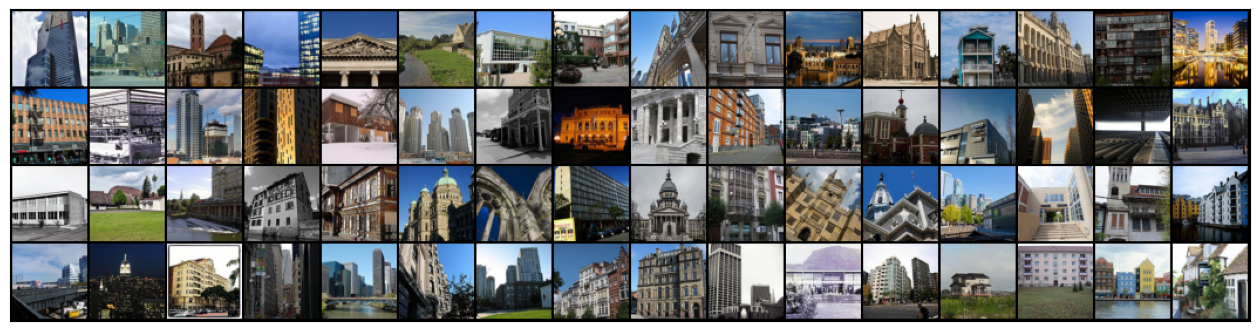

In [37]:
show_batch_images(test_loader)

This time, we will create a function to see a batch of images with their labels.

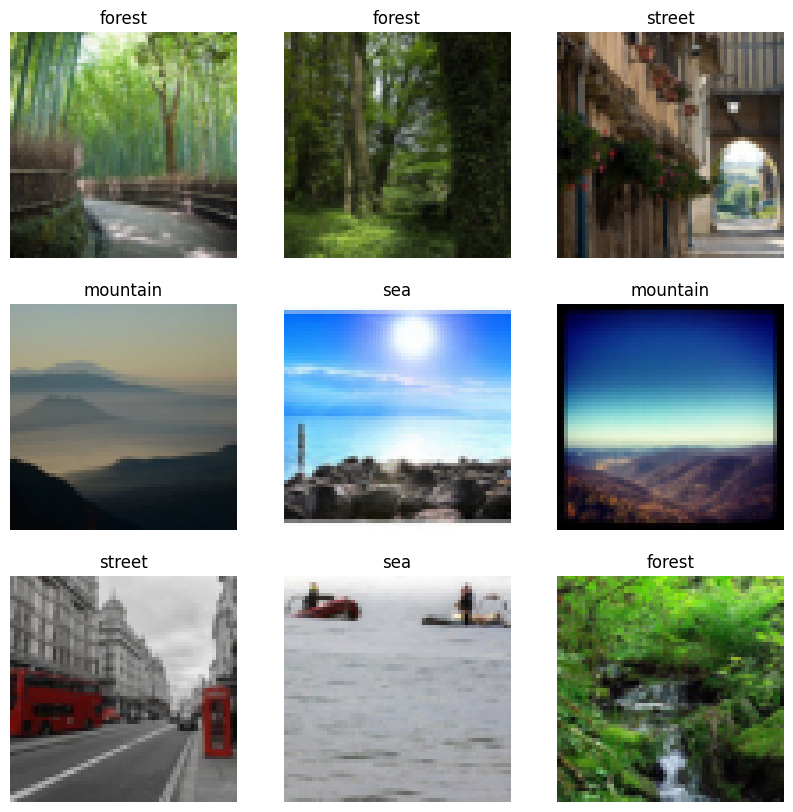

In [38]:
plt.figure(figsize=(10, 10)) # Creating a new figure with a size of 10x10 inches.

# These lines create a list of indices corresponding to the samples in the train_dataset and shuffle them randomly using the random.shuffle() function. This is done to select a random set of images from the dataset for display.
indices = list(range(len(train_dataset)))
random.shuffle(indices)

for i in range(9):

    index = indices[i] # Index is set to the i-th shuffled index from the indices list.
    
    image, label = train_dataset[index] # The image and label corresponding to the index are extracted from the train_dataset
    
    ax = plt.subplot(3, 3, i + 1) # Creating a subplot in the figure at the i-th position in the 3x3 grid.
    
    ax.imshow(image.permute(1, 2, 0)) # displays the image in the subplot. 
    
    ax.set_title(train_dataset.dataset.classes[label]) #  sets the title of the subplot to the corresponding class label of the image.
    
    ax.axis("off") # turns off the axis ticks and labels for the subplot.

plt.show()

Creating our network model.


The model consists of three convolutional layers followed by max pooling operations. The input image has three color channels (RGB) and is processed by each convolutional layer, gradually increasing the number of channels from 16 to 32 and then to 64. 

After each convolutional layer, a ReLU activation function is applied to introduce non-linearity. Max pooling with a kernel size of 2x2 and stride of 2 is performed after each activation to reduce spatial dimensions. 

The output of the last pooling layer is flattened and passed through two fully connected layers. The first fully connected layer has 6488 = 4096 input features, which are then reduced to 256 units using ReLU activation. 

A dropout layer with a rate of 0.5 is applied to prevent overfitting. Finally, the output is passed through another fully connected layer with 6 units, representing the 6 classes of the classification task.

In [39]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 6)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

Creating an instance of the CNN model.


In [40]:
model = CNN()

Defining the loss function and the optimizer.

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Creating the training loop.

In [42]:
num_epochs = 30   # Specifying the number of epochs for training.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Assigning the device (GPU or CPU) based on the availability of a CUDA-enabled GPU. This line ensures that the model and data are moved to the available device.
model.to(device) # Moving the model to the specified device.

for epoch in range(num_epochs): # Creating a for loop to train the model according to the epoch number we specified.
    
    model.train() # Setting the model to training mode, to enable features like dropout and batch normalization.
    
    running_loss = 0.0 # Initializing a variable to keep track of the cumulative loss within the current epoch.
    
    for images, labels in train_loader: # Iterates over the training data loader, which provides batches of images and their corresponding labels for training.
        
        images = images.to(device) # Moving the input images to the specified device.
        labels = labels.to(device) # Moving the target labels to the specified device.
        
        optimizer.zero_grad() # Clearing the gradients of all optimized parameters before calculating the gradients for the current batch.
        
        outputs = model(images) # Passing the images through the model to obtain the predicted outputs.
        loss = criterion(outputs, labels) # Computing the loss between the predicted outputs and the actual labels using a specified criterion.

        loss.backward() # Backpropagating the gradients of the loss through the model to compute the gradients of the model's parameters.
        optimizer.step() # Updating the model's parameters using the computed gradients and the chosen optimizer.
        
        running_loss += loss.item() # Accumulating the loss value for the current batch to calculate the average loss later.
    
    # Calculating average loss for the epoch.
    train_loss = running_loss / len(train_loader)
    
    # Validation loop
    model.eval() # Setting the model to evaluation mode, disabling features like dropout to evaluate the model's performance.
    # Initializing variables to calculate the validation loss and accuracy.
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad(): # Temporarily disabling gradient calculation during validation to save memory and speed up computation.
        
        for images, labels in val_loader: # This loop iterates over the validation data loader to evaluate the model's performance on the validation set.
            
            # Moving images and labels to the specified device.
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images) # The validation images are passed through the model to obtain the predicted outputs.
            loss = criterion(outputs, labels) # This line computes the loss between the predicted outputs and the actual labels using a specified criterion.
            val_loss += loss.item() # The loss value for the current batch is accumulated to calculate the average validation loss later.
            
            # This line finds the predicted labels by selecting the index with the maximum value from the predicted outputs. The underscore (_) is used to ignore the actual values since only the indices are needed.
            _, predicted = torch.max(outputs.data, 1)
            
            # It adds the batch size (number of labels in the current batch) to the total count of labels, keeping track of the total number of samples.
            total += labels.size(0)
            
            # This line calculates the number of correct predictions by comparing the predicted labels with the actual labels. It sums the number of correct predictions and converts it to a Python scalar using the .item() method.
            correct += (predicted == labels).sum().item()
    
    # Calculating average loss and accuracy for the validation set.
    val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total
    
    # Printing the progress for every epoch.
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2%}")

    # Testing loop
    model.eval() # This line sets the model to evaluation mode, disabling features like dropout to evaluate the model's performance consistently.
    # These lines initialize variables to calculate the test loss and accuracy.
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad(): # Temporarily disabling gradient calculation during validation to save memory and speed up computation.
        
        for images, labels in test_loader: # This loop iterates over the test data loader to evaluate the model's performance on the test set, where each iteration provides a batch of images and their corresponding labels.
            
            # These lines move the test batch (images and labels) to the specified device (GPU or CPU) for processing.
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images) # The test images are passed through the model to obtain the predicted outputs.
            loss = criterion(outputs, labels) # This line computes the loss between the predicted outputs and the actual labels using a specified criterion.
            test_loss += loss.item() # The loss value for the current batch is accumulated to calculate the average test loss later.
            
            _, predicted = torch.max(outputs.data, 1) # This line finds the predicted labels by selecting the index with the maximum value from the predicted outputs. The underscore (_) is used to ignore the actual values since only the indices are needed.
            total += labels.size(0) # It adds the batch size (number of labels in the current batch) to the total count of labels, keeping track of the total number of samples.
            correct += (predicted == labels).sum().item() # This line calculates the number of correct predictions by comparing the predicted labels with the actual labels. It sums the number of correct predictions and converts it to a Python scalar using the .item() method.

    # Calculating average loss and accuracy for the test set.
    test_loss = test_loss / len(test_loader)
    test_accuracy = correct / total
    
    # Printing the calculated test loss and test accuracy.
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2%}")

Epoch [1/30], Train Loss: 1.2096, Val Loss: 0.9549, Val Acc: 63.14%
Test Loss: 0.9851, Test Acc: 60.67%
Epoch [2/30], Train Loss: 0.9141, Val Loss: 0.8769, Val Acc: 67.13%
Test Loss: 0.8963, Test Acc: 66.47%
Epoch [3/30], Train Loss: 0.8121, Val Loss: 0.7556, Val Acc: 70.15%
Test Loss: 0.7859, Test Acc: 69.30%
Epoch [4/30], Train Loss: 0.7377, Val Loss: 0.7142, Val Acc: 73.15%
Test Loss: 0.7586, Test Acc: 72.43%
Epoch [5/30], Train Loss: 0.7114, Val Loss: 0.7497, Val Acc: 70.92%
Test Loss: 0.7874, Test Acc: 70.20%
Epoch [6/30], Train Loss: 0.6512, Val Loss: 0.6872, Val Acc: 74.81%
Test Loss: 0.7112, Test Acc: 74.57%
Epoch [7/30], Train Loss: 0.6011, Val Loss: 0.6051, Val Acc: 77.52%
Test Loss: 0.6313, Test Acc: 77.17%
Epoch [8/30], Train Loss: 0.5799, Val Loss: 0.6144, Val Acc: 77.32%
Test Loss: 0.6249, Test Acc: 77.87%
Epoch [9/30], Train Loss: 0.5331, Val Loss: 0.5763, Val Acc: 79.08%
Test Loss: 0.5971, Test Acc: 79.20%
Epoch [10/30], Train Loss: 0.5020, Val Loss: 0.5742, Val Acc: 78

We are going to display some inputs with true and predicted labes to see the accuracy of our model.

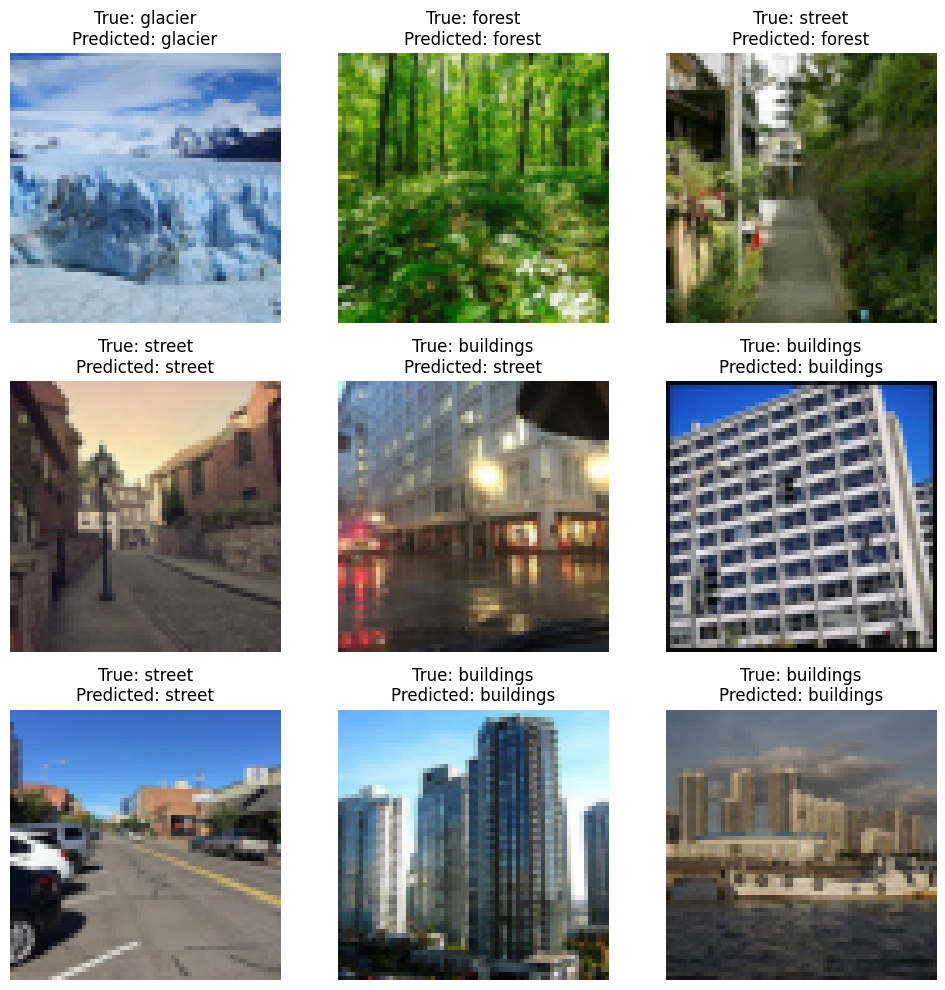

In [44]:
num_samples = 9  # Number of samples to display.

plt.figure(figsize=(10, 10)) # This line creates a new figure for the plot with a specified figure size of 10x10 inches.

plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Adjusting spacing between subplots. The wspace parameter controls the horizontal spacing, and the hspace parameter controls the vertical spacing.

for i in range(num_samples): # This loop iterates num_samples times to display the specified number of predictions.
    
    index = random.randint(0, len(test_dataset) - 1)  # This line generates a random index within the range of the test dataset. It is used to select a random sample from the dataset for prediction and visualization.
    
    image, label = test_dataset[index] # This line retrieves the image and its corresponding label from the test dataset based on the randomly generated index.
    
    image = image.unsqueeze(0).to(device)  # The image tensor is modified to have an additional dimension (batch dimension) at index 0. This is required because the model expects inputs in batch format. The modified image tensor is also moved to the same device as the model.
    
    output = model(image) # The modified image tensor is passed through the model to obtain the predicted output tensor.
    
    predicted_label = torch.argmax(output, dim=1).item() # This line finds the predicted label by selecting the index with the highest value from the predicted output tensor. The .item() method is used to obtain the scalar value of the predicted label.

    plt.subplot(3, 3, i + 1) # This line specifies the subplot configuration for the current iteration of the loop. It creates a subplot grid with 3 rows, 3 columns, and the index i + 1. The i + 1 ensures that the subplots are sequentially filled.
    
    # image.squeeze(): Removes any dimensions with a size of 1 from the image tensor. 
    # .permute(1, 2, 0): Reorders the dimensions of the image tensor to match the expected format for visualization. The dimensions are permuted from (channels, height, width) to (height, width, channels).
    plt.imshow(image.squeeze().cpu().permute(1, 2, 0))  # .cpu(): Moves the image tensor back to the CPU (if it was on a GPU) to enable plotting with Matplotlib.
    
    plt.title(f"True: {train_dataset.dataset.classes[label]}\nPredicted: {train_dataset.dataset.classes[predicted_label]}") # Printing the labels.
    
    plt.axis("off") # Turning off the axis labels and ticks in the current subplot.

plt.tight_layout() # Automatically adjusts the spacing between subplots in the figure.

plt.show()